## Loading Data

In [1]:
path = 'dataset_commands'

In [2]:
import tensorflow as tf
import pathlib
import numpy as np

2024-09-25 15:00:58.348354: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-25 15:00:58.403671: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-25 15:00:58.418526: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-25 15:00:58.516354: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-25 15:00:59.538530: W tensorflow/compiler/tf2

In [3]:
def read_files(path):
    data_dir = pathlib.Path(path)

    all_audio_paths = list(data_dir.glob('*/**/*.wav'))
    all_labels = [path.parent.name for path in all_audio_paths]

    # Converter caminhos para strings
    all_audio_paths = [str(path) for path in all_audio_paths]

    return all_audio_paths, all_labels

In [4]:
all_audio_paths, all_labels = read_files(path)

## Understanding the data

All labels:

In [5]:
np.unique(all_labels)

array(['_background_noise_', 'backward', 'bed', 'bird', 'cat', 'dog',
       'down', 'eight', 'five', 'follow', 'forward', 'four', 'go',
       'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off',
       'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three',
       'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero'], dtype='<U18')

Number of labels:

In [6]:
np.unique(all_labels).shape

(36,)

### Visualizing an audio

2024-09-25 15:01:03.256544: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20974 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:35:00.0, compute capability: 8.9


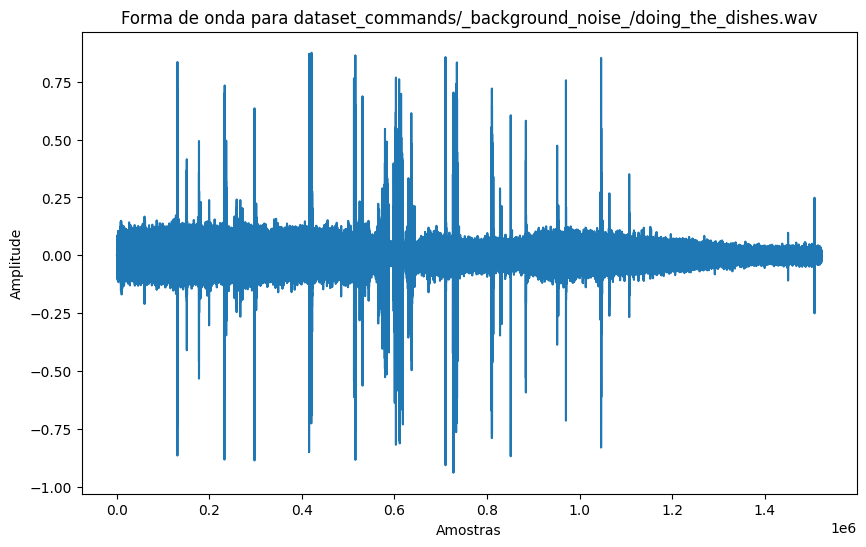

In [7]:
import matplotlib.pyplot as plt

# Reading one example of audio
example_audio_path = all_audio_paths[0]
audio_binary = tf.io.read_file(example_audio_path)
audio, _ = tf.audio.decode_wav(audio_binary)
audio = tf.squeeze(audio, axis=-1)

# Ploting the audio
plt.figure(figsize=(10, 6))
plt.plot(audio.numpy())
plt.title(f'Forma de onda para {example_audio_path}')
plt.xlabel('Amostras')
plt.ylabel('Amplitude')
plt.show()


## Preprocessing

In [8]:
from scipy.signal import resample

In [9]:
def load_and_process_audio(filename, max_length=16000):
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    
    def scipy_resample(wav, sample_rate):
        if sample_rate != 16000:
            wav = resample(wav, int(16000 / sample_rate * len(wav)))
        return wav
    
    wav = tf.py_function(scipy_resample, [wav, sample_rate], tf.float32)
    
    audio_length = tf.shape(wav)[0]
    if audio_length > max_length:
        wav = wav[:max_length]
    else:
        pad_length = max_length - audio_length
        paddings = [[0, pad_length]]
        wav = tf.pad(wav, paddings, 'CONSTANT')
        
    return tf.reshape(wav, [max_length])

In [10]:
def process_path(file_path, label):
    audio = load_and_process_audio(file_path)
    return audio, label

In [11]:
def paths_and_labels_to_dataset(audio_paths, labels):
    path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    audio_label_ds = tf.data.Dataset.zip((path_ds, label_ds))
    return audio_label_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)